# Holstein (semi-classical)

## Initialize variables and imports

In [1]:
import numpy
from scipy import linalg, special, integrate, optimize
from scipy.integrate import solve_ivp
import matplotlib
from matplotlib import pyplot
import pandas
import gc
import os

from tqdm.notebook import tqdm

import joblib

import bmme

In [28]:
omega = .3
lamda = .15                            # .03, .15, .3, .6 eV
epsilon = .15  
Gamma = .01                            # .01, .026, .05 eV
T = .026

fix_epsilon = True
if fix_epsilon:
    epsilon_fixed = epsilon
    epsilon += lamda**2 / omega
    
def file_apx():
    return f"{'ef' if fix_epsilon else 'e'}{(epsilon_fixed if fix_epsilon else epsilon):.3f}_omega{omega:.3f}_lamda{lamda:.3f}_Gamma{Gamma:.3f}"

#print(file_apx(), epsilon)

## Plot Langevin quantities

Voltage: 0.3 V


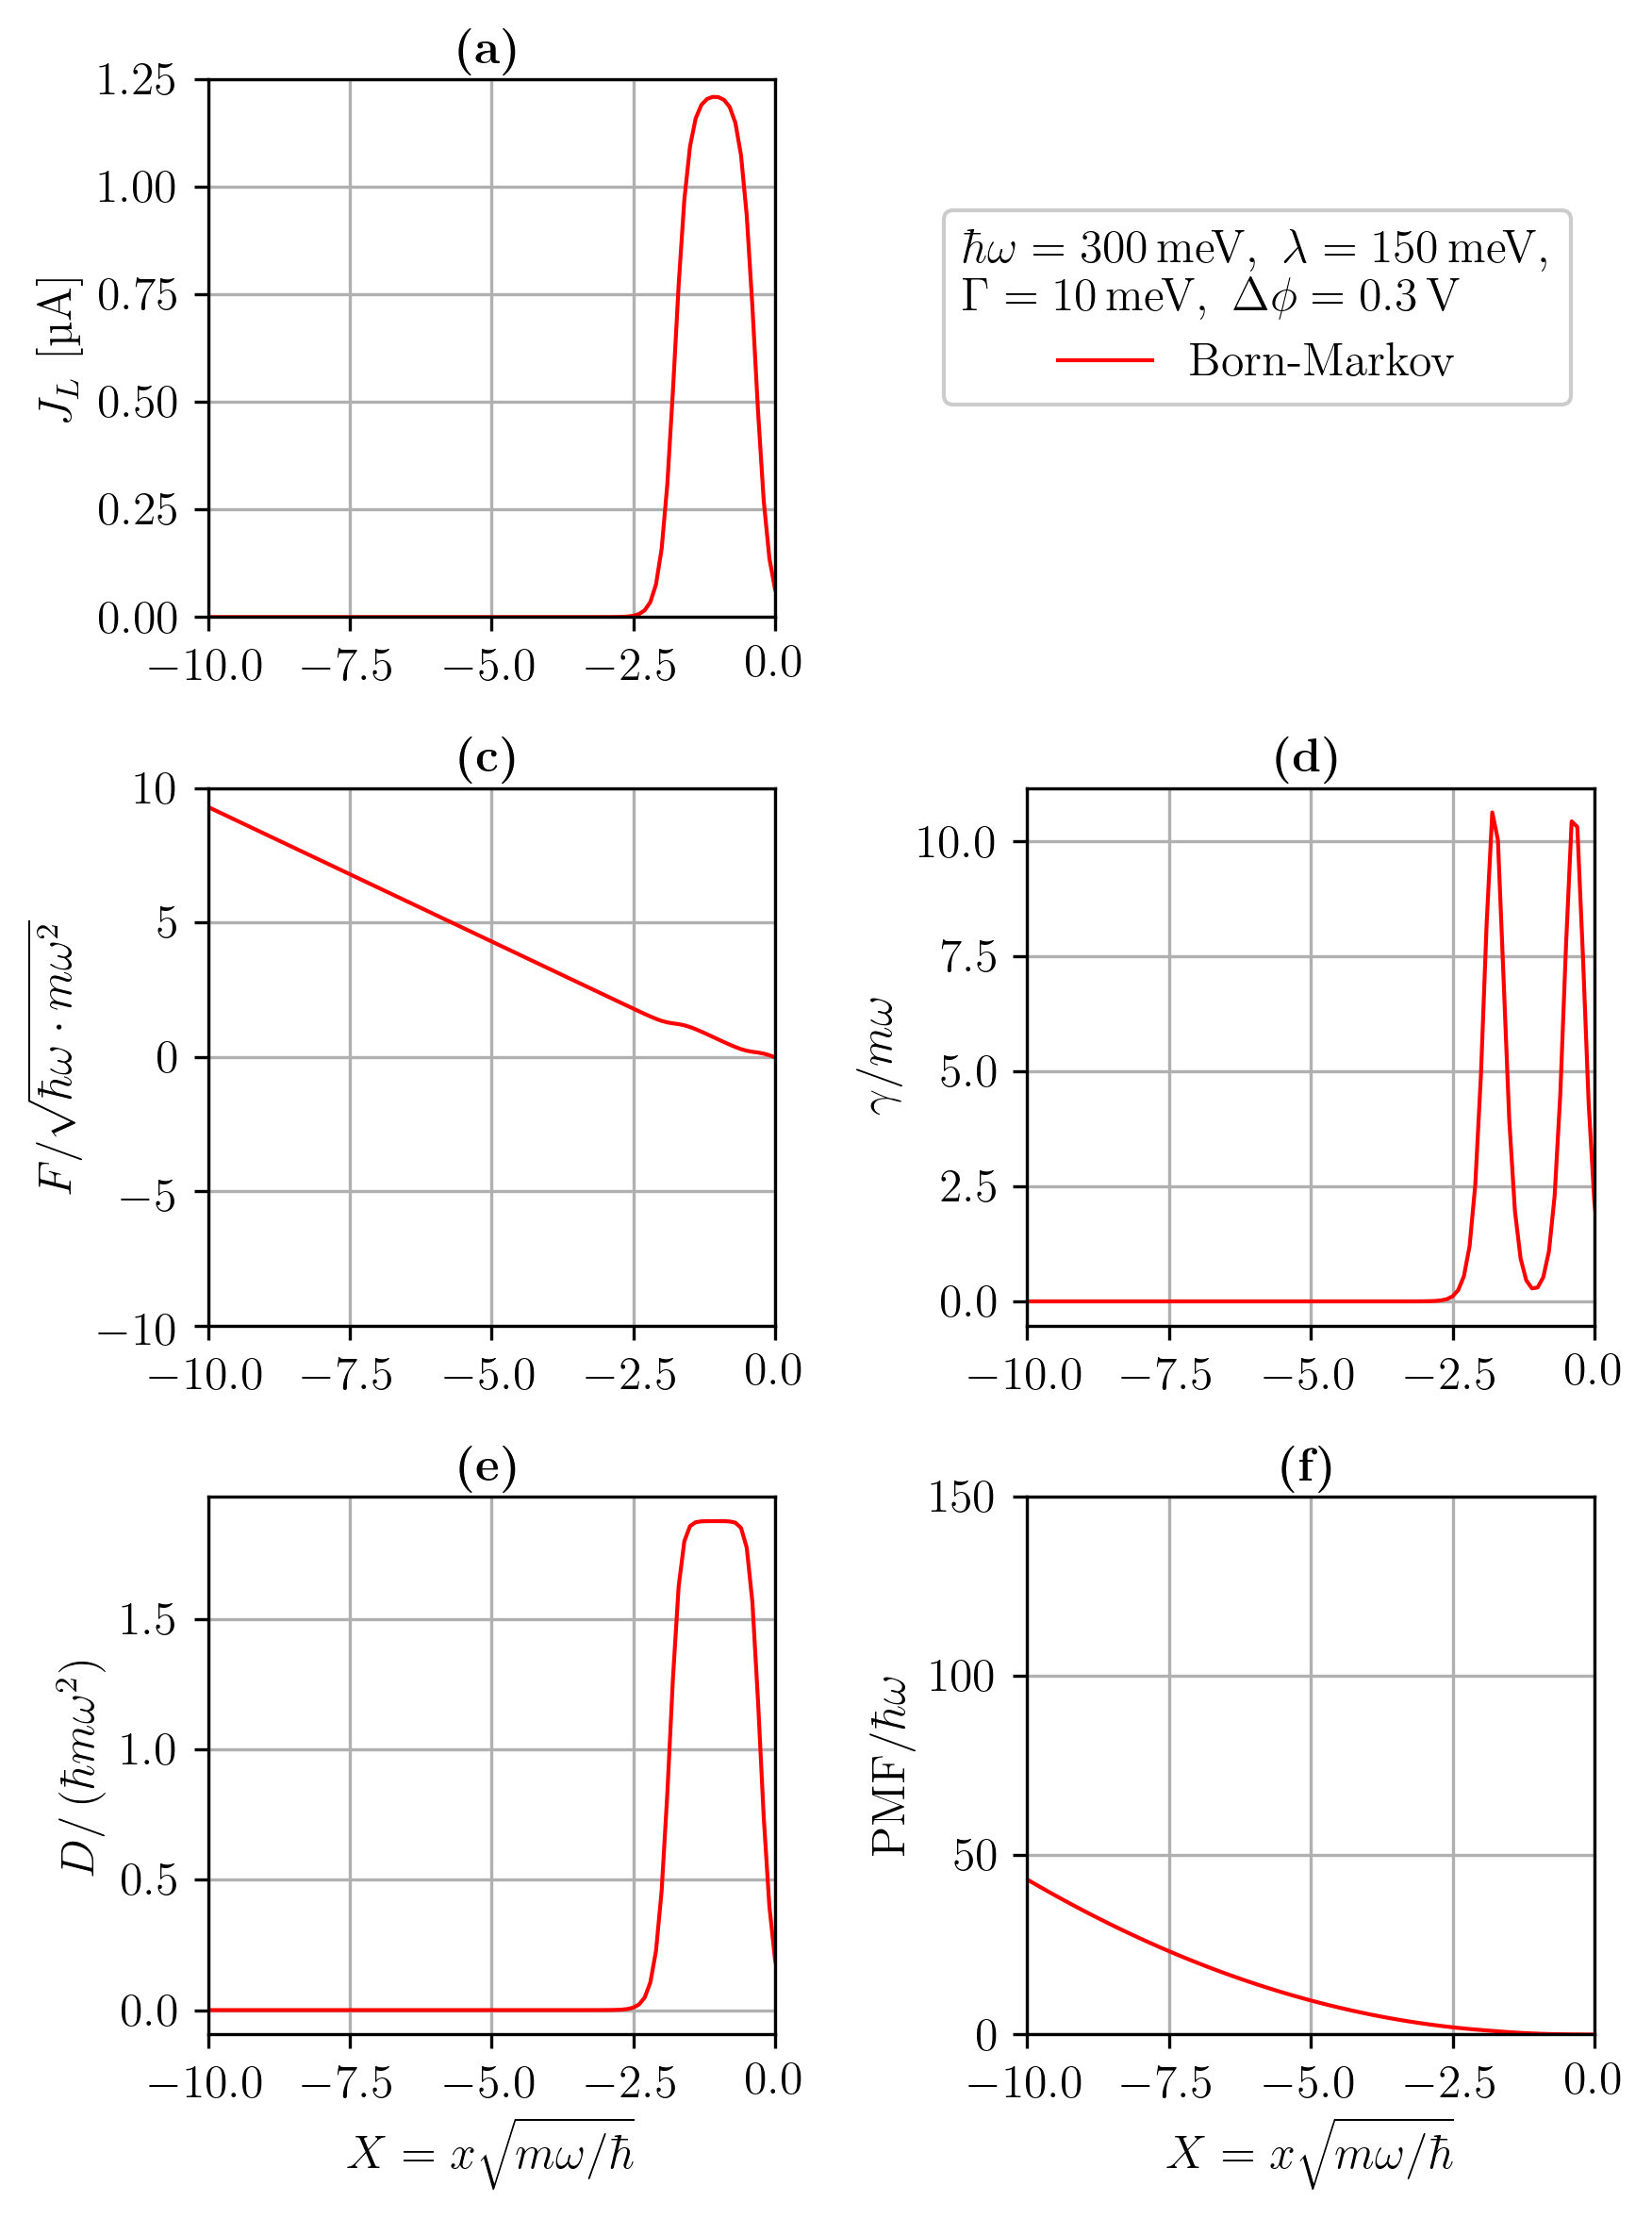

In [27]:
voltage = 300

print(f"Voltage: {voltage*1e-3} V")

panda = pandas.read_csv(f"data/holstein_semicl/langevin_bmme_{file_apx()}.csv")
panda = panda[panda["voltage"] == voltage]

grid = panda["X"].to_numpy()
mean_force = panda["mean_force"].to_numpy()

# ===== Read Sam's HEOM data =====
include_heom = os.path.isfile(f"data/holstein_semicl/langevin_heom_{file_apx()}.csv")
if include_heom:
    hpanda = pandas.read_csv(f"data/holstein_semicl/langevin_heom_{file_apx()}.csv")
    hpanda = hpanda[hpanda["voltage"] == voltage]
    hgrid = hpanda["X"].to_numpy()
    hmean_force = hpanda["mean_force"].to_numpy()

#portrait: 
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pyplot.subplots(3, 2, figsize=(6, 8), tight_layout=True)
#landscape:
#fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = pyplot.subplots(2, 3, figsize=(10, 5), tight_layout=True)

#grid = x1

unit = "\\mathrm{meV}"
unit2 = "\\mathrm{V}"

PMF = -numpy.cumsum(mean_force / omega)
PMF *= (grid[-1] - grid[0]) / (len(grid) - 1)
PMF -= numpy.amin(PMF)

if include_heom:
    hPMF = -numpy.cumsum(hmean_force / omega)
    hPMF *= (hgrid[-1] - hgrid[0]) / (len(hgrid) - 1)
    hPMF -= numpy.amin(hPMF)

def do_plot(panda, fmt, lw, label):
    grid = panda["X"].to_numpy()
    for ax, data, factor in [(ax1, "current_L", 1.), (ax2, "current_L", 1.), 
                             (ax3, "mean_force", 1/omega), (ax4, "friction", 1.), 
                             (ax5, "diffusion", 1/omega), (ax6, None, 1.)]:
        if data:
            ax.plot(grid, panda[data].to_numpy() * factor, fmt, lw=lw, label=label)
        ax.grid('on')
        ax.set_xlim(-10., 0.)

do_plot(panda, "-r", lw=1., label="Born-Markov")
ax6.plot(grid, PMF, "-r", lw=1., label="Born-Markov")

if include_heom:
    do_plot(hpanda, "--b", lw=.7, label="HEOM")
    ax6.plot(hgrid, hPMF, "--b", lw=.7, label="HEOM")

ax1.set_title("\\textbf{(a)}", fontdict={"fontsize":"medium"}, pad=4)
ax3.set_title("\\textbf{(c)}", fontdict={"fontsize":"medium"}, pad=4)
ax4.set_title("\\textbf{(d)}", fontdict={"fontsize":"medium"}, pad=4)
ax5.set_title("\\textbf{(e)}", fontdict={"fontsize":"medium"}, pad=4)
ax6.set_title("\\textbf{(f)}", fontdict={"fontsize":"medium"}, pad=4)

ax5.set_xlabel("$X=x\\sqrt{m\\omega/\\hbar}$")
ax6.set_xlabel("$X=x\\sqrt{m\\omega/\\hbar}$")

ax1.set_ylabel("$J_L$ [µA]")
ax2.set_ylabel("$J_L$ [µA]")
ax3.set_ylabel("$F/\\sqrt{\\hbar\\omega\\cdot m\\omega^2}$")
ax4.set_ylabel("$\\gamma/m\\omega$")
ax5.set_ylabel("$D/\\left(\\hbar m\\omega^2\\right)$")
ax6.set_ylabel("PMF/$\\hbar\\omega$")

ax2.legend(bbox_to_anchor=(0., -.2, 1., 1.), framealpha=1.0, title=f"$\\hbar\\omega={(1e3*omega):.0f}\\,{unit},\\ \\lambda={(1e3*lamda):.0f}\\,{unit},$\n$\\Gamma={(1e3*Gamma):.0f}\\,{unit},\\ \\Delta\\phi={voltage*1e-3:.1f}\\,{unit2}$")
ax2.axis('off')

ax1.set_ylim(0., 1.25)
ax2.set_ylim(-2, -1)
ax3.set_ylim(-10., 10.)
#ax4.set_ylim(0., 50.)
#ax5.set_ylim(0., .1)
ax6.set_ylim(0., 150.)

pyplot.gcf().set_dpi(300)
#pyplot.savefig(f"holstein_semicl_langevin_2.pdf")
pyplot.show()

## Plot mean values

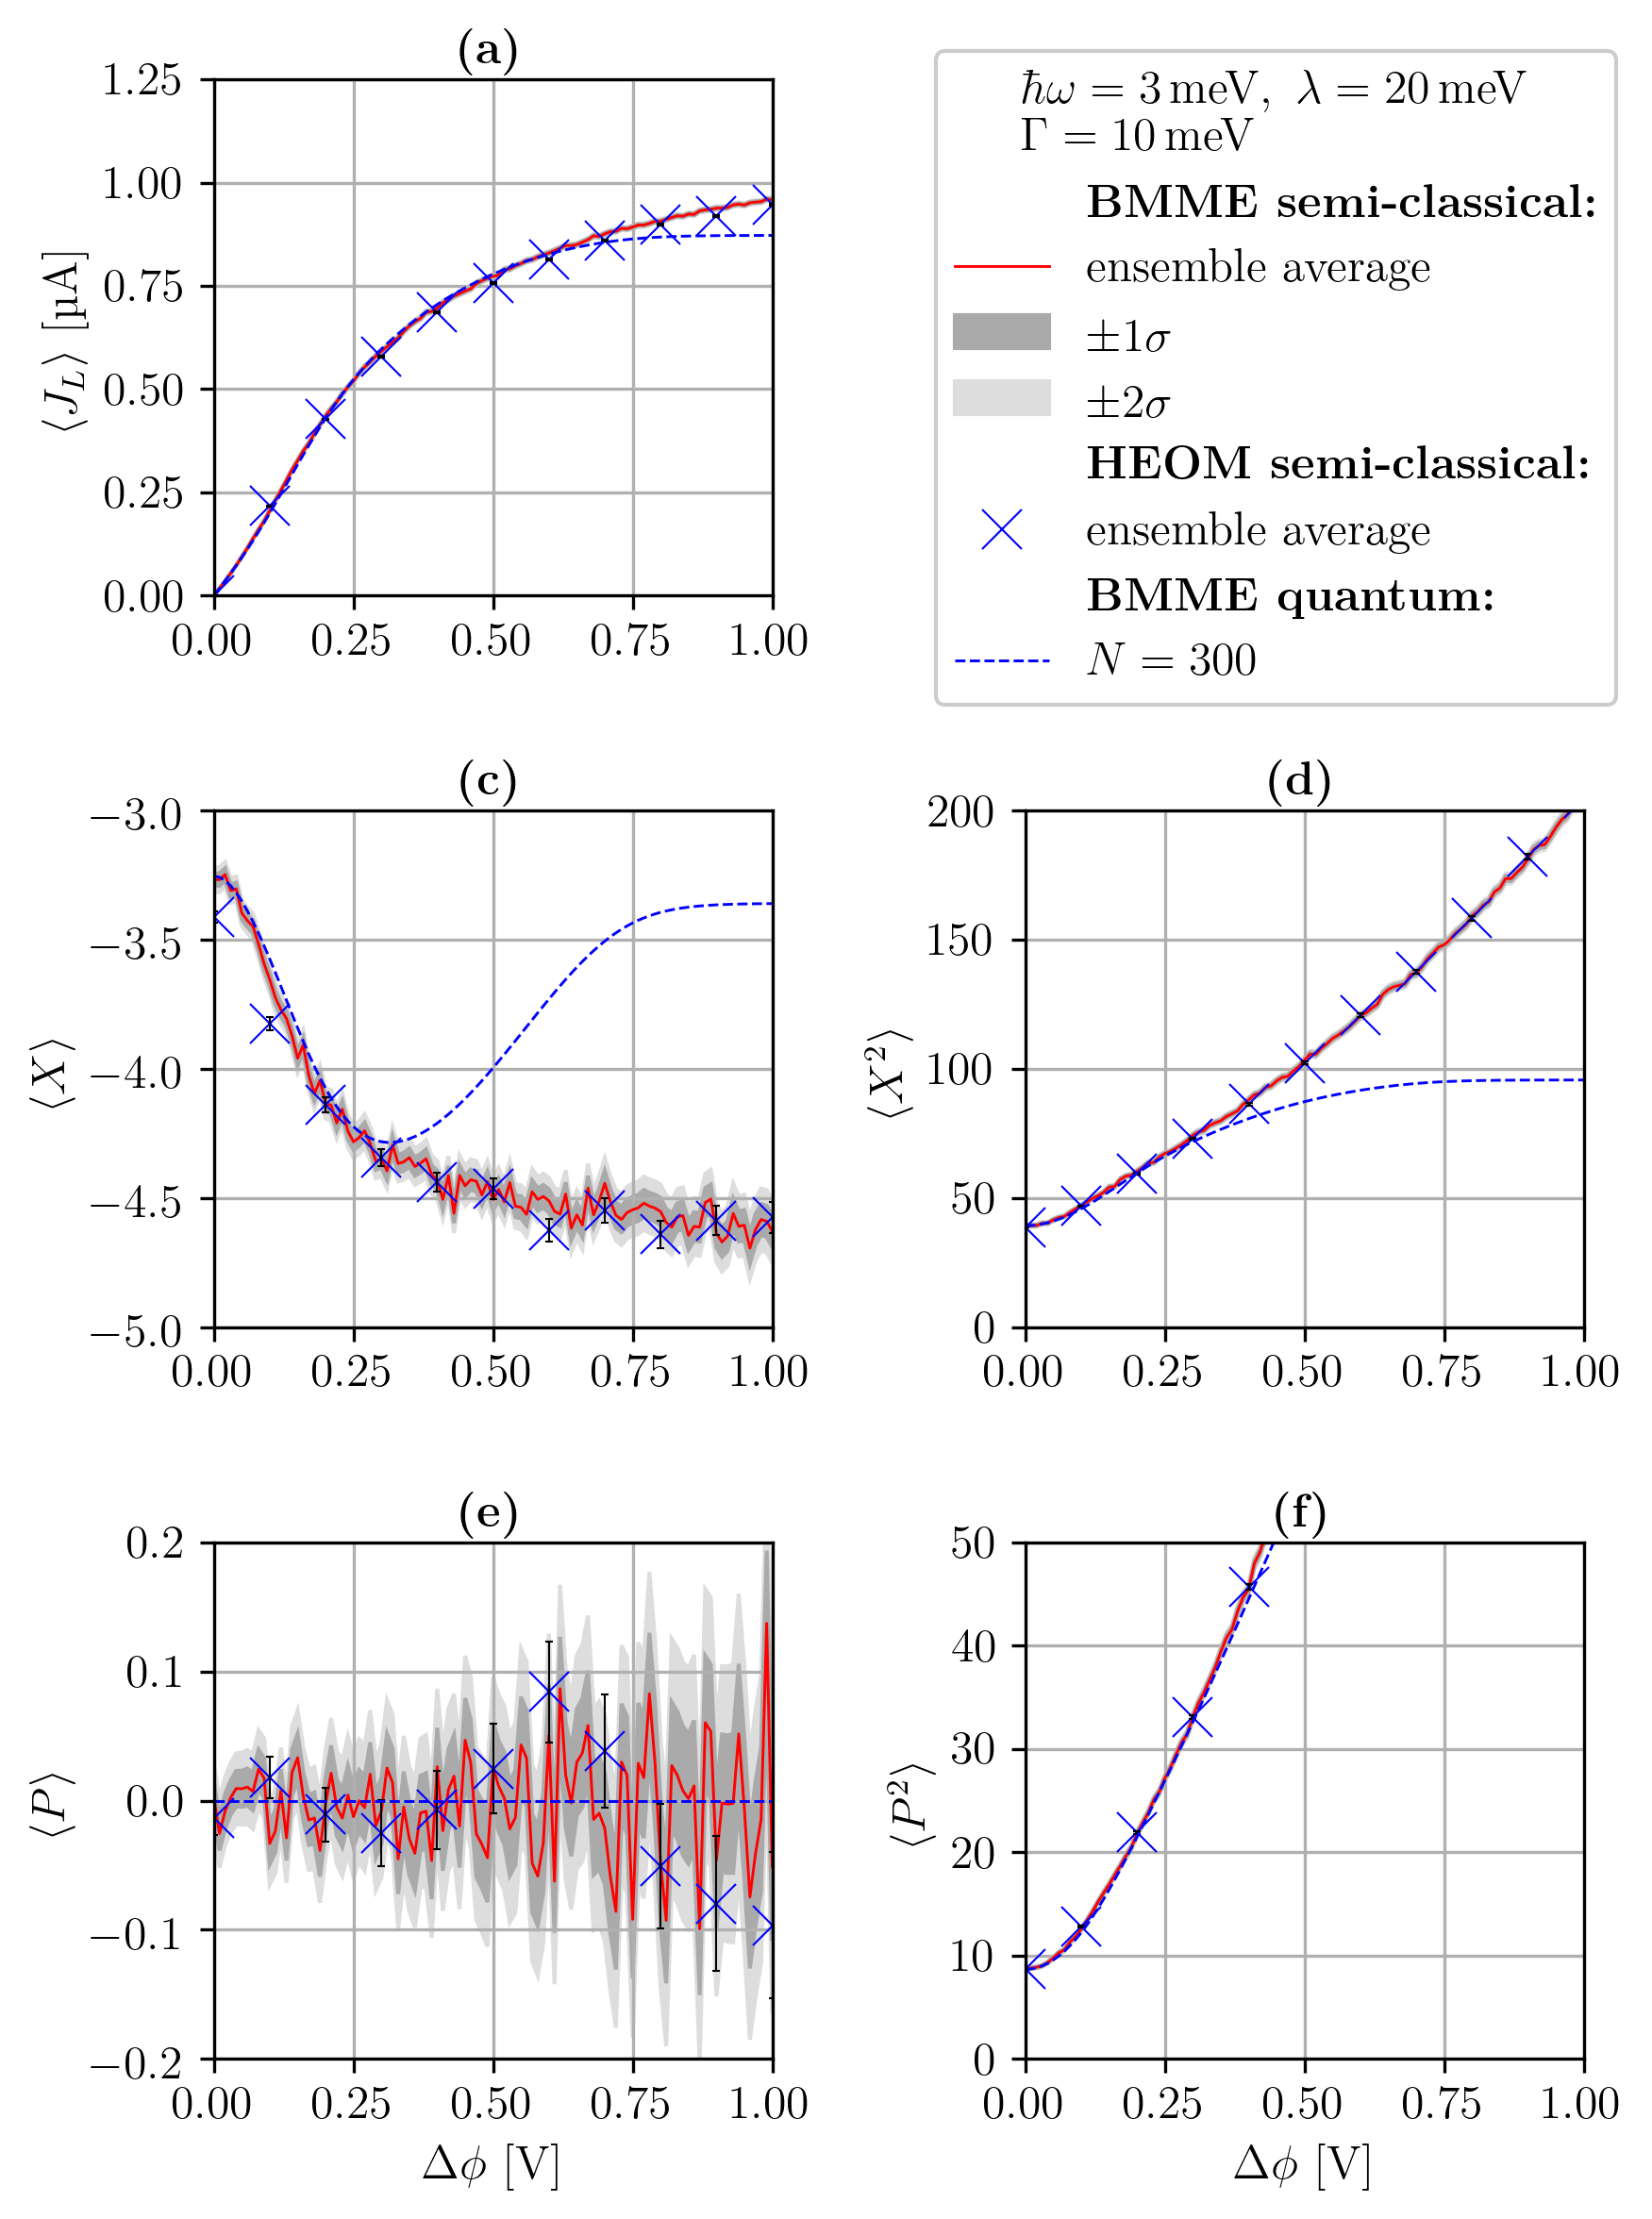

In [19]:
panda = pandas.read_csv(f"data/holstein_semicl/classical_bmme_{file_apx()}.csv")

# ===== Read Sam's HEOM data =====
include_heom = os.path.isfile(f"data/holstein_semicl/classical_heom_{file_apx()}.csv")
if include_heom:
    hpanda = pandas.read_csv(f"data/holstein_semicl/classical_heom_{file_apx()}.csv")

# ===== Read BMME quantum data =====
quantum_N = [(150, 250)]
#quantum_N = [(75, 150), (150, 250)]
qpanda = []
for (N, N_diag) in quantum_N:
    qpanda.append(pandas.read_csv(f"data/holstein_semicl/quantum_bmme_{file_apx()}_N{N}~{N_diag}.csv"))

#portrait: 
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pyplot.subplots(3, 2, figsize=(6, 8), tight_layout=True)
#landscape:
#fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = pyplot.subplots(2, 3, figsize=(10, 5), tight_layout=True)

unit = "\\mathrm{meV}"

def do_plot_area(panda, fmt, lw, label):
    x = panda["voltage"].to_numpy()*1e-3
    for ax, data in [(ax1, "current_L"), (ax2, "current_L"), 
                     (ax3, "X"), (ax4, "X^2"), 
                     (ax5, "P"), (ax6, "P^2")]:
        y = panda[data].to_numpy()
        u_y = panda["u_" + data].to_numpy()
        ax.plot(x, y, fmt, lw=lw, label=label)
        ax.fill(numpy.concatenate((x, x[::-1])), numpy.concatenate((y + u_y, y[::-1] - u_y[::-1])), c="#aaaaaa", label="$\\pm1\\sigma$", zorder=1.)
        ax.fill(numpy.concatenate((x, x[::-1])), numpy.concatenate((y + 2*u_y, y[::-1] - 2*u_y[::-1])), c="#dddddd", label="$\\pm2\\sigma$", zorder=0.)
        
        ax.grid('on')
        ax.set_xlim(0., 1.)
        ax.set_xticks([0., .25, .5, .75, 1.])

def do_plot_points(panda, fmt, ms, mew, label):
    x = panda["voltage"].to_numpy()*1e-3
    for ax, data in [(ax1, "current_L"), (ax2, "current_L"), 
                     (ax3, "X"), (ax4, "X^2"), 
                     (ax5, "P"), (ax6, "P^2")]:
        y = panda[data].to_numpy()
        u_y = panda["u_" + data].to_numpy()
        ax.plot(x, y, fmt, ms=ms, label=label, mew=mew)
        ax.errorbar(x, y, yerr=u_y, fmt="x", ms=0., ecolor="k", capsize=1., capthick=.5, elinewidth=.5)
        #ax.fill(numpy.concatenate((x, x[::-1])), numpy.concatenate((y + u_y, y[::-1] - u_y[::-1])), c="#aaaaaa", label="$\\pm1\\sigma$", zorder=1.)
        #ax.fill(numpy.concatenate((x, x[::-1])), numpy.concatenate((y + 2*u_y, y[::-1] - 2*u_y[::-1])), c="#dddddd", label="$\\pm2\\sigma$", zorder=0.)
        
        ax.grid('on')
        ax.set_xlim(0., 1.)
        ax.set_xticks([0., .25, .5, .75, 1.])
        
def do_plot_line(panda, fmt, lw, label):
    x = panda["voltage"].to_numpy()*1e-3
    for ax, data in [(ax1, "current_L"), (ax2, "current_L"), 
                     (ax3, "X"), (ax4, "X^2"), 
                     (ax5, "P"), (ax6, "P^2")]:
        y = panda[data].to_numpy()
        ax.plot(x, y, fmt, lw=lw, label=label)
        
        ax.grid('on')
        ax.set_xlim(0., 1.)
        ax.set_xticks([0., .25, .5, .75, 1.])

ax2.plot(-1e3, -1e3, alpha=0.0, label="\\textbf{BMME semi-classical:}")
do_plot_area(panda, "-r", lw=.7, label="ensemble average")

if include_heom:
    ax2.plot(-1e3, -1e3, alpha=0.0, label="\\textbf{HEOM semi-classical:}")
    do_plot_points(hpanda, "xb", ms=10., mew=.5, label="ensemble average")
    
if len(quantum_N):
    ax2.plot(-1e3, -1e3, alpha=0.0, label="\\textbf{BMME quantum:}")
    q_colors = {25: "b", 50: "m", 75: "g", 100: "b", 150: "b"}
    for i, (N, N_diag) in enumerate(quantum_N):
        do_plot_line(qpanda[i], "--" + q_colors[N], lw=.7, label=f"$N={quantum_N[i][0]*2}$")

ax1.set_title("\\textbf{(a)}", fontdict={"fontsize":"medium"}, pad=4)
ax3.set_title("\\textbf{(c)}", fontdict={"fontsize":"medium"}, pad=4)
ax4.set_title("\\textbf{(d)}", fontdict={"fontsize":"medium"}, pad=4)
ax5.set_title("\\textbf{(e)}", fontdict={"fontsize":"medium"}, pad=4)
ax6.set_title("\\textbf{(f)}", fontdict={"fontsize":"medium"}, pad=4)

ax5.set_xlabel("$\\Delta\\phi$ [V]")
ax6.set_xlabel("$\\Delta\\phi$ [V]")

ax1.set_ylabel("$\\langle J_L\\rangle$ [µA]")
ax2.set_ylabel("$\\langle J_L\\rangle$ [µA]")
ax3.set_ylabel("$\\langle X\\rangle$")
ax4.set_ylabel("$\\langle X^2\\rangle$")
ax5.set_ylabel("$\\langle P\\rangle$")
ax6.set_ylabel("$\\langle P^2\\rangle$")

ax2.legend(bbox_to_anchor=(.1, .1, 1., 1.), framealpha=1.0, title=f"$\\hbar\\omega={(1e3*omega):.0f}\\,{unit},\\ \\lambda={(1e3*lamda):.0f}\\,{unit}$\n$\\Gamma={(1e3*Gamma):.0f}\\,{unit}$")
ax2.axis('off')

ax1.set_ylim(0., 1.25)
ax2.set_ylim(-2, -1)
ax3.set_ylim(-5, -3)
ax4.set_ylim(0., 200.)
ax5.set_ylim(-.2, .2)
ax6.set_ylim(0., 50.)

pyplot.gcf().set_dpi(300)
#pyplot.savefig(f"holstein_semicl_ensavg_17.pdf")
pyplot.show()

## Plot final mean values

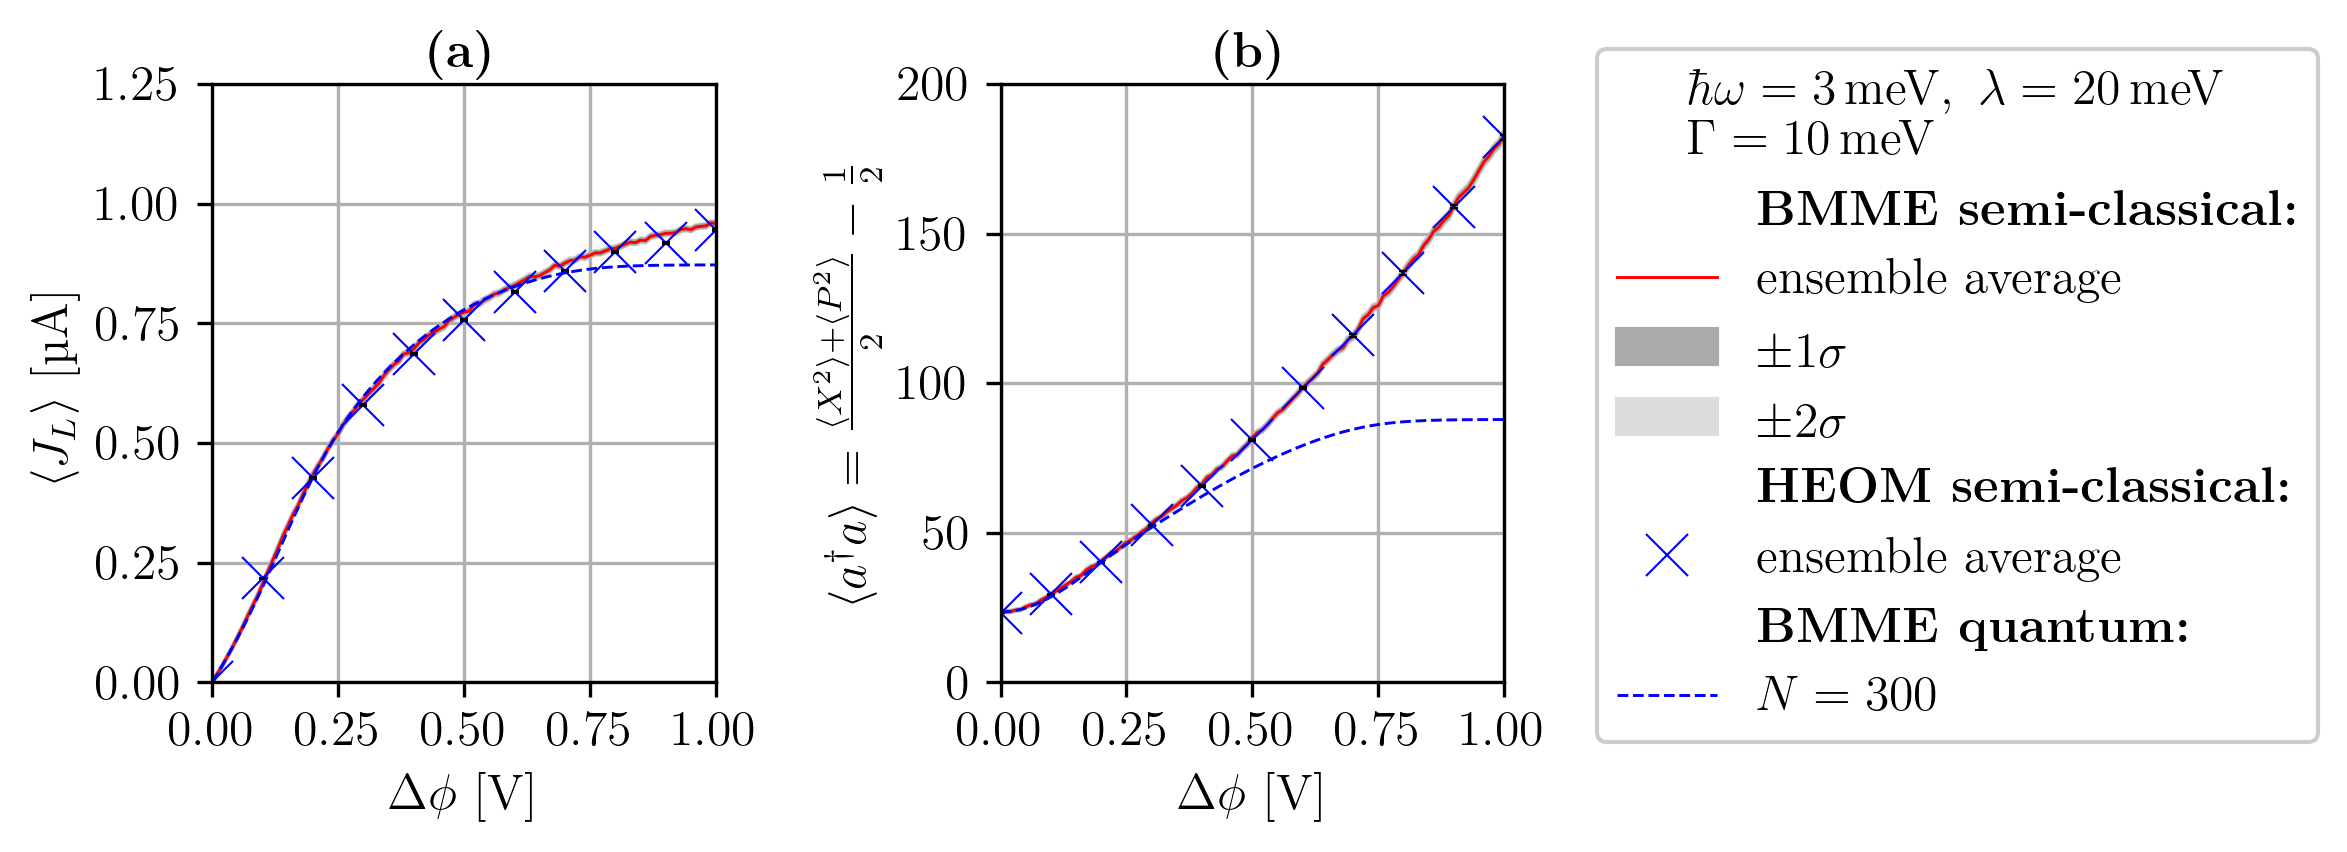

In [14]:
panda = pandas.read_csv(f"data/holstein_semicl/classical_bmme_{file_apx()}.csv")

# ===== Read Sam's HEOM data =====
include_heom = os.path.isfile(f"data/holstein_semicl/classical_heom_{file_apx()}.csv")
if include_heom:
    hpanda = pandas.read_csv(f"data/holstein_semicl/classical_heom_{file_apx()}.csv")

# ===== Read BMME quantum data =====
quantum_N = [(150, 250)]
#quantum_N = [(75, 150), (150, 250)]
qpanda = []
for (N, N_diag) in quantum_N:
    qpanda.append(pandas.read_csv(f"data/holstein_semicl/quantum_bmme_{file_apx()}_N{N}~{N_diag}.csv"))

#portrait: 
#fig, (ax1, ax2, ax3) = pyplot.subplots(3, 1, figsize=(4, 8), tight_layout=True)
#landscape: 
fig, (ax1, ax2, ax3) = pyplot.subplots(1, 3, figsize=(8, 3), tight_layout=True)

unit = "\\mathrm{meV}"

def do_plot_area(panda, fmt, lw, label):
    x = panda["voltage"].to_numpy()*1e-3
    for ax, y, u_y in [(ax1, panda["current_L"].to_numpy(), panda["u_current_L"].to_numpy()),
                       (ax3, panda["current_L"].to_numpy(), panda["u_current_L"].to_numpy()),
                       (ax2, 0.5 * (panda["X^2"].to_numpy() + panda["P^2"].to_numpy()) - 0.5,
                        numpy.sqrt((0.5 * panda["u_X^2"].to_numpy())**2 + (0.5 * panda["u_P^2"].to_numpy())**2))]:
        ax.plot(x, y, fmt, lw=lw, label=label)
        ax.fill(numpy.concatenate((x, x[::-1])), numpy.concatenate((y + u_y, y[::-1] - u_y[::-1])), c="#aaaaaa", label="$\\pm1\\sigma$", zorder=1.)
        ax.fill(numpy.concatenate((x, x[::-1])), numpy.concatenate((y + 2*u_y, y[::-1] - 2*u_y[::-1])), c="#dddddd", label="$\\pm2\\sigma$", zorder=0.)
        
        ax.grid('on')
        ax.set_xlim(0., 1.)
        ax.set_xticks([0., .25, .5, .75, 1.])

def do_plot_points(panda, fmt, ms, mew, label):
    x = panda["voltage"].to_numpy()*1e-3
    for ax, y, u_y in [(ax1, panda["current_L"].to_numpy(), panda["u_current_L"].to_numpy()),
                       (ax3, panda["current_L"].to_numpy(), panda["u_current_L"].to_numpy()),
                       (ax2, 0.5 * (panda["X^2"].to_numpy() + panda["P^2"].to_numpy()) - 0.5,
                        numpy.sqrt((0.5 * panda["u_X^2"].to_numpy())**2 + (0.5 * panda["u_P^2"].to_numpy())**2))]:
        ax.plot(x, y, fmt, ms=ms, label=label, mew=mew)
        ax.errorbar(x, y, yerr=u_y, fmt="x", ms=0., ecolor="k", capsize=1., capthick=.5, elinewidth=.5)
        #ax.fill(numpy.concatenate((x, x[::-1])), numpy.concatenate((y + u_y, y[::-1] - u_y[::-1])), c="#aaaaaa", label="$\\pm1\\sigma$", zorder=1.)
        #ax.fill(numpy.concatenate((x, x[::-1])), numpy.concatenate((y + 2*u_y, y[::-1] - 2*u_y[::-1])), c="#dddddd", label="$\\pm2\\sigma$", zorder=0.)
        
        ax.grid('on')
        ax.set_xlim(0., 1.)
        ax.set_xticks([0., .25, .5, .75, 1.])
        
def do_plot_line(panda, fmt, lw, label):
    x = panda["voltage"].to_numpy()*1e-3
    for ax, y in [(ax1, panda["current_L"].to_numpy()), (ax3, panda["current_L"].to_numpy()), 
                  (ax2, panda["excitation"].to_numpy())]:
        ax.plot(x, y, fmt, lw=lw, label=label)
        
        ax.grid('on')
        ax.set_xlim(0., 1.)
        ax.set_xticks([0., .25, .5, .75, 1.])

ax3.plot(-1e3, -1e3, alpha=0.0, label="\\textbf{BMME semi-classical:}")
do_plot_area(panda, "-r", lw=.7, label="ensemble average")

if include_heom:
    ax3.plot(-1e3, -1e3, alpha=0.0, label="\\textbf{HEOM semi-classical:}")
    do_plot_points(hpanda, "xb", ms=10., mew=.5, label="ensemble average")
    
if len(quantum_N):
    ax3.plot(-1e3, -1e3, alpha=0.0, label="\\textbf{BMME quantum:}")
    q_colors = {25: "b", 50: "m", 75: "g", 100: "b", 150: "b"}
    for i, (N, N_diag) in enumerate(quantum_N):
        do_plot_line(qpanda[i], "--" + q_colors[N], lw=.7, label=f"$N={quantum_N[i][0]*2}$")

ax1.set_title("\\textbf{(a)}", fontdict={"fontsize":"medium"}, pad=4)
ax2.set_title("\\textbf{(b)}", fontdict={"fontsize":"medium"}, pad=4)

ax1.set_xlabel("$\\Delta\\phi$ [V]")
ax2.set_xlabel("$\\Delta\\phi$ [V]")

ax1.set_ylabel("$\\langle J_L\\rangle$ [µA]")
ax2.set_ylabel("$\\langle a^\dagger a\\rangle=\\frac{\\langle X^2\\rangle+\\langle P^2\\rangle}{2}-\\frac{1}{2}$")
ax3.set_ylabel("$\\langle J_L\\rangle$ [µA]")

ax3.legend(bbox_to_anchor=(.1, .1, 1., 1.), framealpha=1.0, title=f"$\\hbar\\omega={(1e3*omega):.0f}\\,{unit},\\ \\lambda={(1e3*lamda):.0f}\\,{unit}$\n$\\Gamma={(1e3*Gamma):.0f}\\,{unit}$")
ax3.axis('off')

ax1.set_ylim(0., 1.25)
ax2.set_ylim(0., 200.)
ax3.set_ylim(-2, -1)

pyplot.gcf().set_dpi(300)
#pyplot.savefig(f"holstein_semicl_ensavg_17.pdf")
pyplot.show()

In [38]:
numpy.repeat(numpy.array([1,2,3]), (2))

array([1, 1, 2, 2, 3, 3])